### Import Libraries

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import numpy as np

2024-06-25 23:29:43.315196: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-25 23:29:43.348390: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 23:29:43.884463: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data extraction

In [2]:
# Load the CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 31s 0us/step


In [3]:
# Initialize an array to hold one image per class
images_per_class = np.zeros((10, 32, 32, 3), dtype=np.uint8)
labels_per_class = np.zeros(10, dtype=int)

# Find one image per class
for i in range(10):
    idx = np.where(train_labels == i)[0][0]  # Find the first index of class i
    images_per_class[i] = train_images[idx]
    labels_per_class[i] = train_labels[idx][0]

# Class names in CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

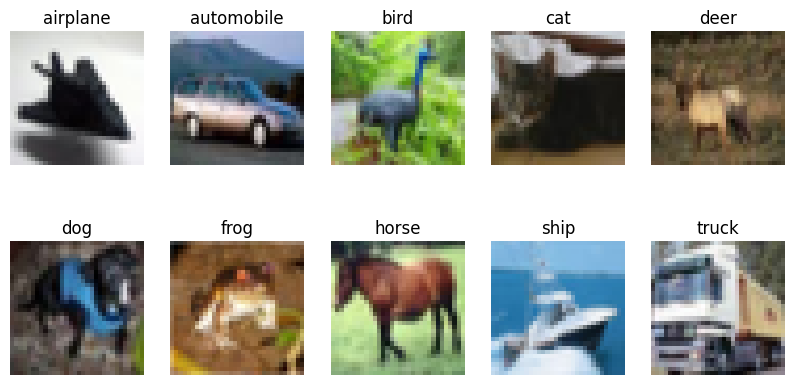

In [4]:
# Set up the matplotlib figure and axes
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)  # Create a subplot for each image
    plt.imshow(images_per_class[i])
    plt.title(class_names[i])
    plt.axis('off')

plt.show()

In [5]:
# Split the original training data to create a new training set and a validation set.
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [6]:
# Normalize pixel values to be between 0 and 1
train_images, test_images, val_images = train_images / 255.0, test_images / 255.0, val_images/ 255.0

## CNN Architecture Definition: LeNet-5

Here, a sequential convolutional neural network (CNN) model is defined, inspired by the LeNet-5 architecture, which is adapted for color images (32x32 pixels with 3 color channels). The model consists of the following layers:
1. **First Convolutional Layer**: This layer has 6 filters of size 5x5 and uses 'relu' activation. It processes the input image directly.
2. **First Average Pooling Layer**: Reduces the spatial dimensions (width and height) by taking the average over a 2x2 pooling window.
3. **Second Convolutional Layer**: Increases the depth to 16 filters, also of size 5x5 with 'relu' activation.
4. **Second Average Pooling Layer**: Further reduces the spatial dimensions, helping to focus on higher-level features.
5. **Flattening Layer**: Transforms the 2D feature maps into a 1D feature vector, necessary for the fully connected layers that follow.
6. **First Dense Layer**: A fully connected layer with 120 units and 'relu' activation.
7. **Second Dense Layer**: Another dense layer with 84 units, maintaining 'relu' activation.
8. **Output Layer**: The final layer with 10 units (one for each class of CIFAR-10) and 'softmax' activation for multi-class classification.

In [7]:
# Define the CNN architecture
model = models.Sequential([
    layers.Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 3), padding='valid'),
    layers.AveragePooling2D((2, 2), padding='valid'),
    layers.Conv2D(16, (5, 5), activation='relu', padding='valid'),
    layers.AveragePooling2D((2, 2), padding='valid'),
    layers.Flatten(),
    layers.Dense(120, activation='relu'),
    layers.Dense(84, activation='relu'),
    layers.Dense(10, activation='softmax')  # Output layer with softmax activation
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

/home/vladplyusnin/tftest/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-25 23:30:43.400705: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-25 23:30:43.493033: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-25 23:30:43.493076: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 6)      │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,006 (242.21 KB)

 Trainable params: 62,006 (242.21 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(train_images, train_labels, epochs=20, 
                    validation_data=(val_images, val_labels))

Epoch 1/20


I0000 00:00:1719315058.098940   16059 service.cc:145] XLA service 0x7f62fc005910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719315058.099015   16059 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-06-25 23:30:58.133275: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-25 23:30:58.296658: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900


 102/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1367 - loss: 2.2492

I0000 00:00:1719315062.179944   16059 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1719315062.182783   16059 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.2988 - loss: 1.8953 - val_accuracy: 0.4577 - val_loss: 1.4943
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4845 - loss: 1.4310 - val_accuracy: 0.5278 - val_loss: 1.3161
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5355 - loss: 1.2956 - val_accuracy: 0.5610 - val_loss: 1.2325
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5711 - loss: 1.1978 - val_accuracy: 0.5710 - val_loss: 1.2153
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5961 - loss: 1.1350 - val_accuracy: 0.5860 - val_loss: 1.1818
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6094 - loss: 1.0882 - val_accuracy: 0.5813 - val_loss: 1.1839
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6365 - loss: 1.0286 - val_accuracy: 0.6029 - val_loss: 1.1546
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6530 - loss: 0.9720 - val_accurac

In [9]:
def predict_and_evaluate(model):
    # Predict classes with the model
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)

    # Flatten the test labels array to match predicted_classes dimensions
    true_classes = test_labels.flatten()

    # Print classification report
    print(classification_report(true_classes, predicted_classes, target_names=class_names))

In [10]:
predict_and_evaluate(model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

    airplane       0.65      0.69      0.67      1000
  automobile       0.75      0.73      0.74      1000
        bird       0.58      0.44      0.50      1000
         cat       0.40      0.44      0.42      1000
        deer       0.54      0.52      0.53      1000
         dog       0.53      0.48      0.51      1000
        frog       0.65      0.71      0.68      1000
       horse       0.61      0.71      0.66      1000
        ship       0.75      0.72      0.73      1000
       truck       0.68      0.68      0.68      1000

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.61     10000
weighted avg       0.61      0.61      0.61     10000



The model performs best with classes like "Automobile" and "Ship", showing higher precision and recall.
Challenges are evident in classes with lower metrics such as "Cat" and "Dog", likely due to the variability in these categories or similar features with other classes.
The overall accuracy and averages indicate a balanced model performance, but there is room for improvement, especially in classes with lower scores.

In [12]:
#Create function for plot a training history
def plot_training_history(history):
    # Convert the history.history dict to a pandas DataFrame
    history_df = pd.DataFrame(history.history)

    # Determine the maximum loss value for setting ylim
    max_loss = history_df[['loss', 'val_loss']].max().max()  # Gets the highest loss value from both 'loss' and 'val_loss'
    max_ylim = max_loss + max_loss * 0.1  # Adds a 10% margin to the maximum loss value for better visualization

    # Define the style for each line
    styles = ["r--", "r--.", "b-", "b-*"]  # Adjust based on actual metrics in history

    # Plot the dataframe specifying style and legends
    history_df.plot(
        figsize=(8, 5),
        xlim=[0, len(history_df) - 1],  # Adjust x limits to the number of epochs
        ylim=[0, max_ylim],  # Adjust y limits according to the range of metrics
        grid=True,
        xlabel="Epoch",
        style=styles
    )

    plt.legend(loc="lower left")
    plt.show()

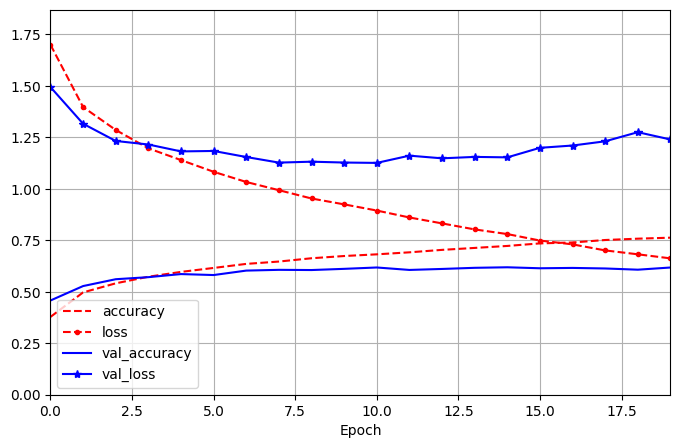

In [13]:
plot_training_history(history)

The training loss decreasing while the training accuracy increases is a typical sign of model learning. However, the high initial training loss might suggest that the model started with a poor understanding of the data.
The validation loss decreasing less steeply than the training loss and the relatively flat validation accuracy indicate potential issues such as overfitting, where the model learns to perform well on the training data but less so on data it hasn't seen before.

## MaxPooling

MaxPooling helps the network become invariant to small changes and distortions in the image. Since it picks the maximum value, slight variations in the background or other less important features are less likely to affect the output, making MaxPooling more robust for recognizing key features in varied contexts.
By focusing on the highest signals in the receptive fields, MaxPooling can help reduce overfitting.This is because it provides an abstracted form of the features, reducing the chances of the model learning noise and irrelevant details.

In [14]:
# Define the CNN architecture
modelMaxPooling = models.Sequential([
    layers.Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 3), padding='valid'),
    layers.MaxPooling2D((2, 2), padding='valid'),
    layers.Conv2D(16, (5, 5), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2), padding='valid'),
    layers.Flatten(),
    layers.Dense(120, activation='relu'),
    layers.Dense(84, activation='relu'),
    layers.Dense(10, activation='softmax')  # Output layer with softmax activation
])

# Compile the model
modelMaxPooling.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
modelMaxPooling.summary()

/home/vladplyusnin/tftest/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 6)      │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,006 (242.21 KB)

 Trainable params: 62,006 (242.21 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = modelMaxPooling.fit(train_images, train_labels, epochs=20, 
                    validation_data=(val_images, val_labels))

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3058 - loss: 1.8700 - val_accuracy: 0.4779 - val_loss: 1.4579
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4809 - loss: 1.4407 - val_accuracy: 0.5112 - val_loss: 1.3558
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5252 - loss: 1.3250 - val_accuracy: 0.5377 - val_loss: 1.2986
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5549 - loss: 1.2423 - val_accuracy: 0.5504 - val_loss: 1.2763
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5822 - loss: 1.1700 - val_accuracy: 0.5627 - val_loss: 1.2378
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5994 - loss: 1.1290 - val_accuracy: 0.5573 - val_loss: 1.2644
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6224 - loss: 1.0642 - val_accuracy: 0.5800 - val_loss: 1.2014
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6418 - loss: 1.0084 - 

In [16]:
predict_and_evaluate(modelMaxPooling)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

    airplane       0.64      0.64      0.64      1000
  automobile       0.73      0.63      0.68      1000
        bird       0.52      0.48      0.50      1000
         cat       0.41      0.36      0.38      1000
        deer       0.54      0.50      0.52      1000
         dog       0.51      0.36      0.42      1000
        frog       0.62      0.75      0.68      1000
       horse       0.66      0.65      0.65      1000
        ship       0.64      0.76      0.70      1000
       truck       0.54      0.72      0.62      1000

    accuracy                           0.59     10000
   macro avg       0.58      0.59      0.58     10000
weighted avg       0.58      0.59      0.58     10000



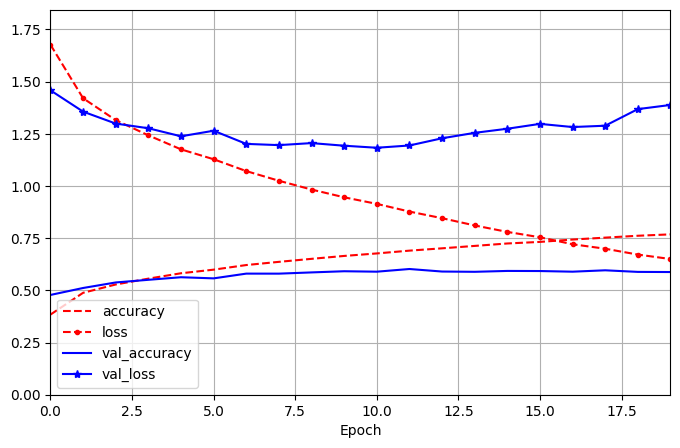

In [17]:
plot_training_history(history)

Switching from average pooling to max pooling significantly improved the classification accuracy for the cat, dog, and bird classes. Additionally, the model achieved a performance plateau more quickly compared to when average pooling was used. This change indicates that max pooling is more effective at capturing the distinguishing features necessary for accurate classification in these categories.
The validation loss starts to plateau and even increase slightly after the 12.5-epoch mark, which might suggest the onset of overfitting as the model begins to memorize the training data rather than learning to generalize from it.

### Same padding

The images used in this model are of small dimensions, specifically 32x32 pixels. As these images pass through multiple convolutional layers, their spatial dimensions are reduced. This significant reduction in size leads to a loss of important visual information, which affect the model's accuracy.

To mitigate this issue, 'same padding' is employed in the convolutional layers. Same padding helps maintain the image dimensions throughout the convolutional layers, ensuring that the spatial size of the output feature maps remains the same as that of the input.  

In [ ]:
# Define the CNN architecture
modelSamePadding = models.Sequential([
    layers.Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 3), padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(16, (5, 5), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Flatten(),
    layers.Dense(120, activation='relu'),
    layers.Dense(84, activation='relu'),
    layers.Dense(10, activation='softmax')  # Output layer with softmax activation
])

# Compile the model
modelSamePadding.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
modelSamePadding.summary()

In [ ]:
history = modelSamePadding.fit(train_images, train_labels, epochs=20, 
                    validation_data=(val_images, val_labels))

In [ ]:
predict_and_evaluate(modelSamePadding)

Overall accuracy has increased to 0.61. However, while the model now retains more image detail through the layers, leading to improved detection in some classes, it has encountered challenges with more complex classes such as 'Cat' and 'Dog'. These classes showed a decrease in performance metrics, which might suggest that the model is retaining too much unnecessary information, complicating the feature extraction process.

In [ ]:
plot_training_history(history)

With the same number of epochs and learning rate settings, the latest model iteration shows improved results. However, it is important to note that the number of parameters has more than doubled. This significant increase in model complexity could be a contributing factor to the observed performance gains.

After training the third iteration of our model, it becomes evident that the model starts to overfit shortly after the 5th epoch.

## Increasing Number of Convolutional Layers

For small images presented in dataset, increasing the number of convolutional layers can help extract more complex and intricate patterns from the data. This is particularly important for improving the model's ability to discern subtle features and nuances within the images.

In [ ]:
# Define the CNN architecture
modelAddLayers = models.Sequential([
    layers.Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 3), padding='valid'),
    layers.MaxPooling2D((2, 2), padding='valid'),
    layers.Conv2D(64, (5, 5), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2), padding='valid'),
    layers.Flatten(),
    layers.Dense(120, activation='relu'),
    layers.Dense(84, activation='relu'),
    layers.Dense(10, activation='softmax')  # Output layer with softmax activation
])

# Compile the model
modelAddLayers.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
modelAddLayers.summary()

In [ ]:
history = modelAddLayers.fit(train_images, train_labels, epochs=20, 
                    validation_data=(val_images, val_labels))

In [ ]:
predict_and_evaluate(modelAddLayers)

In [ ]:
plot_training_history(history)

While this model has achieved a better accuracy score compared to previous iterations, the persistent overfitting problem remains unresolved. Additionally, it's worth noting that the performance metrics for the 'cat' and 'dog' classes still lag behind, indicating challenges in accurately classifying these categories.

## Kernel Size Reduction

To improve the model's ability to classify 'cat' and 'dog' classes, we've decided to decrease the kernel size in the convolutional layers. This adjustment aims to allow the model to capture more intricate patterns within the images, potentially leading to better classification accuracy. Additionally, I've augmented the model architecture by adding more convolutional layers. This expansion allows the model to store a greater number of learned weights from the new, smaller kernels.

In [ ]:
# Define the CNN architecture
modelKarnel = models.Sequential([
    layers.Conv2D(128, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='valid'),
    layers.MaxPooling2D((2, 2), padding='valid'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2), padding='valid'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2), padding='valid'),
    layers.Flatten(),
    layers.Dense(120, activation='relu'),
    layers.Dense(84, activation='relu'),
    layers.Dense(10, activation='softmax')  # Output layer with softmax activation
])

# Compile the model
modelKarnel.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
modelKarnel.summary()

In [ ]:
history = modelKarnel.fit(train_images, train_labels, epochs=20, 
                    validation_data=(val_images, val_labels))

In [ ]:
predict_and_evaluate(modelKarnel)

In [ ]:
plot_training_history(history)

The model exhibits substantially improved performance across the board, with notable gains observed in the classification of complex classes like 'cat,' 'dog,' and 'bird.' 

## Regularization techniques.

### Batch Normalisation after convolutional layers

It is evident from the training that the model begins to overfit after approximately 8-10 epochs. Batch Normalization assists in mitigating this by normalizing the output of the convolution layers before the activation function is applied. This approach effectively manages internal covariate shift, helping to prevent overfitting and stabilize the training process.

In [ ]:
# Define the CNN architecture
modelBatchNorm = models.Sequential([
    layers.Conv2D(128, (3, 3), input_shape=(32, 32, 3), padding='valid'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2), padding='valid'),
    
    layers.Conv2D(64, (3, 3), padding='valid'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2), padding='valid'),
    
    layers.Conv2D(32, (3, 3), padding='valid'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2), padding='valid'),
    
    layers.Flatten(),
    layers.Dense(120, activation='relu'),
    layers.Dense(84, activation='relu'),
    layers.Dense(10, activation='softmax')  # Output layer with softmax activation
])

# Compile the model
modelBatchNorm.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
modelBatchNorm.summary()

In [ ]:
history = modelBatchNorm.fit(train_images, train_labels, epochs=20, 
                    validation_data=(val_images, val_labels))

In [ ]:
predict_and_evaluate(modelBatchNorm)

In [ ]:
plot_training_history(history)

Batch Normalization significantly enhances model performance by improving generalization, which is reflected in higher precision, recall, and F1-scores for most classes.
Specific improvements are notable in classes such as "cat," "dog," and "burd,".

### Dropout in Fully Connected Layers

During training, Dropout helps in preventing neurons from co-adapting too much, which can lead to overfitting. By doing this, Dropout ensures that the network maintains robustness and generalizes well to new, unseen data.

In [ ]:
# Define the CNN architecture
modelDropout = models.Sequential([
    layers.Conv2D(128, (3, 3), input_shape=(32, 32, 3), padding='valid'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2), padding='valid'),
    
    layers.Conv2D(64, (3, 3), padding='valid'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2), padding='valid'),
    
    layers.Conv2D(32, (3, 3), padding='valid'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2), padding='valid'),
    
    layers.Flatten(),
    layers.Dense(120, activation='relu'),
    layers.Dropout(0.20),
    layers.Dense(84, activation='relu'),
    layers.Dropout(0.10),
    layers.Dense(10, activation='softmax')  # Output layer with softmax activation
])

# Compile the model
modelDropout.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
modelDropout.summary()

In [ ]:
history = modelDropout.fit(train_images, train_labels, epochs=20, 
                    validation_data=(val_images, val_labels))

In [ ]:
predict_and_evaluate(modelDropout)

In [ ]:
plot_training_history(history)

The current model shows suboptimal results. To enhance its performance, it is proposed to integrate Dropout layers into the convolutional sections.

### Dropout in Convolutional Layers

In [18]:
# Define the CNN architecture
modelDropoutB = models.Sequential([
    layers.Conv2D(128, (3, 3), input_shape=(32, 32, 3), padding='valid'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2), padding='valid'),
    layers.Dropout(0.20),
    
    layers.Conv2D(64, (3, 3), padding='valid'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2), padding='valid'),
    layers.Dropout(0.10),
    
    layers.Conv2D(32, (3, 3), padding='valid'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2), padding='valid'),
    
    layers.Flatten(),
    layers.Dense(120, activation='relu'),
    layers.Dense(84, activation='relu'),
    layers.Dense(10, activation='softmax')  # Output layer with softmax activation
])

# Compile the model
modelDropoutB.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
modelDropoutB.summary()

/home/vladplyusnin/tftest/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 13, 13, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 120)            │        15,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,230 (481.37 KB)

 Trainable params: 122,782 (479.62 KB)

 Non-trainable params: 448 (1.75 KB)

In [19]:
history = modelDropoutB.fit(train_images, train_labels, epochs=20, 
                    validation_data=(val_images, val_labels))

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.3942 - loss: 1.6490 - val_accuracy: 0.5564 - val_loss: 1.2516
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5969 - loss: 1.1265 - val_accuracy: 0.5521 - val_loss: 1.2678
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6493 - loss: 0.9845 - val_accuracy: 0.6112 - val_loss: 1.1075
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6848 - loss: 0.8939 - val_accuracy: 0.5933 - val_loss: 1.1657
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7098 - loss: 0.8258 - val_accuracy: 0.6709 - val_loss: 0.9576
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7261 - loss: 0.7909 - val_accuracy: 0.6524 - val_loss: 1.0172
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7375 - loss: 0.7508 - val_accuracy: 0.6161 - val_loss: 1.1967
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7496 - loss: 0.7132 -

In [20]:
predict_and_evaluate(modelDropoutB)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

    airplane       0.71      0.75      0.73      1000
  automobile       0.75      0.89      0.81      1000
        bird       0.70      0.56      0.62      1000
         cat       0.50      0.68      0.58      1000
        deer       0.83      0.53      0.65      1000
         dog       0.86      0.39      0.54      1000
        frog       0.80      0.77      0.78      1000
       horse       0.73      0.72      0.73      1000
        ship       0.73      0.88      0.80      1000
       truck       0.65      0.88      0.75      1000

    accuracy                           0.70     10000
   macro avg       0.73      0.70      0.70     10000
weighted avg       0.73      0.70      0.70     10000



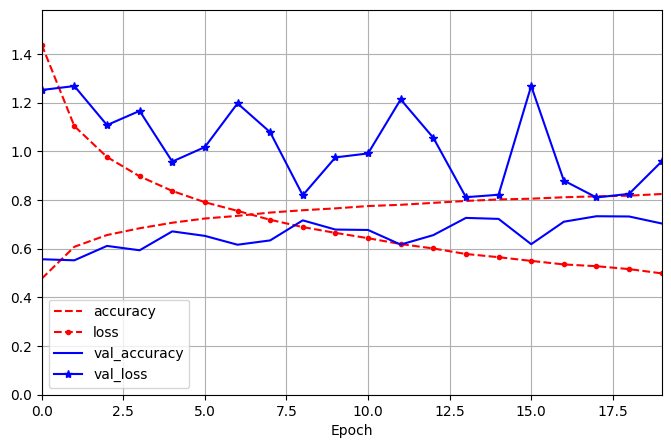

In [21]:
plot_training_history(history)

The updated model, which includes Dropout in the convolutional layers, shows significantly better performance, particularly in complex classes such as 'cat' and 'dog'. This suggests that the model is now better at capturing intricate patterns necessary for distinguishing these categories.

## Summary


Enhancing the depth of Convolutional Neural Networks (CNNs), as inspired by the LeNet-5 architecture adapted for color images, significantly improves performance in complex image classification tasks. This model excels particularly in recognizing 'Automobile' and 'Ship' classes due to its detailed and hierarchical feature representations. However, challenges persist in accurately classifying 'Cat' and 'Dog' classes, which could benefit from additional model tuning.

By adopting a deeper architectural framework, the model gains the capability to capture more nuanced and layered feature representations. This augmentation in layers and parameters, however, leads to increased complexity and requires extended periods for training.

The implementation of Dropout in both fully connected and convolutional layers has demonstrated effectiveness in preventing overfitting, thereby enhancing the robustness and generalization capability of the model, especially in complex categories. Batch normalization further improves model performance by stabilizing the learning process and enhancing generalization, which is reflected in higher precision and recall metrics.

To further improve the model's ability to generalize to new, unseen data, integrating data augmentation techniques is suggested. This approach not only increases the dataset's size and diversity but also extends the training duration due to the increased complexity and volume of data being processed.

## Data Augmentation

As an additional technique, consider using data augmentation. This method artificially enhances the size and diversity of the training dataset, thereby improving the model's ability to generalize to new, unseen data. However, it also extends the training duration due to the increased complexity and volume of data being processed.

In [ ]:
'''datagen = ImageDataGenerator(
    brightness_range=[0.9, 1.1],  
    rotation_range=1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

In [ ]:
'''# Assuming train_images and train_labels
train_datagen = datagen.flow(train_images, train_labels, batch_size=32)